Based on the final project for HarvardX's [Using Python for Research](https://www.edx.org/course/using-python-for-research) course.

Using information gathered by phone telemetry, determine via machine learning if a person is standing still, walking, going up stairs, or going down stairs. The data uses the following encoding: 1 = standing, 2 = walking, 3 = stairs down, 4 = stairs up. Information is gathered in a times series format.


In [1]:
#Handle import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight

#read in the time series data with location information
train_time_series = pd.read_csv("train_time_series.csv", index_col = 0)
#Read in the time data with label information
train_labels = pd.read_csv("train_labels.csv", index_col = 0)
#read in the time data with location information
test_time_series = pd.read_csv("test_time_series.csv", index_col = 0)
#Read in the time data with label information
test_labels = pd.read_csv("test_labels.csv", index_col = 0)

In [2]:
#Add the labels when available by timestamp to the training data
train_data = pd.concat([train_time_series, train_labels.label], axis = 1, sort = False)

In [3]:
#Explore the first few entries to the data
train_data.head()

,timestamp,UTC time,accuracy,x,y,z,label
20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046,NaN
20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554,NaN
20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467,NaN
20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985,1.0
20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450,NaN


In [4]:
#Add the labels when available by timestamp to the target data
test_data = pd.concat([test_time_series, test_labels.label], axis = 1, sort = False)

In [5]:
#Explore the first few entries to the data
test_data.head()

,timestamp,UTC time,accuracy,x,y,z,label
24330,1565110306139,2019-08-06T16:51:46.139,unknown,0.034286,-1.504456,0.157623,NaN
24331,1565110306239,2019-08-06T16:51:46.239,unknown,0.409164,-1.038544,0.030975,NaN
24332,1565110306340,2019-08-06T16:51:46.340,unknown,-0.234390,-0.984558,0.124771,NaN
24333,1565110306440,2019-08-06T16:51:46.440,unknown,0.251114,-0.787003,0.054810,NaN
24334,1565110306540,2019-08-06T16:51:46.540,unknown,0.109924,-0.169510,0.235550,NaN


In [6]:
def delta_data(dataframe, column, delta_name):
    """Function to calculate the change between a the current and previous data entry"""
    previous = 0
    current = 0
    change = []
    for element in dataframe[column]:
        current = element
        change.append((current - previous))
        previous = current
    dataframe[delta_name] = change    

In [7]:
#Transform and clean data to allow for easier processing.
def transform_data(X, y):
    """Function Merges X and y dataframes by X's index, then adds in a 'delta x', 'delta y', 'delta z', and 
    'delta t' column to give additional information to the learning models as needed. Then it creates a new 
    row indicating if the original data had a label then fills in the label data based on the next available 
    entry"""
    #Merges the given dataframes, left means uses the indexes from the X dataframe
    transformed_data = X.merge(y, how = 'left')
    #Add in the calculated columns
    delta_data(transformed_data, 'x', 'delta x')
    delta_data(transformed_data, 'y', 'delta y')
    delta_data(transformed_data, 'z', 'delta z')
    delta_data(transformed_data, 'timestamp', 'delta t')
    #Create a column indicating if the original data contained a label
    transformed_data["NaN"] = transformed_data['label'].isnull()
    #Fill the label dataframe based on the next numeric reading is. 
    transformed_data.fillna(method = 'bfill',inplace = True)
    #return the new dataframe
    return transformed_data

In [8]:
new_train_data = transform_data(train_time_series, train_labels)

In [9]:
def labelChoice(label):
    """Return the type of activity corresponding to each given label."""
    if label == 1:
        return "Standing"
    if label == 2:
        return "Walking"
    if label == 3: 
        return "Going up stairs"
    if label == 4:
        return "Going down stairs"
#Create an array of activities based on the given lables in the training data dataframe
text_labels = [labelChoice(label) for label in new_train_data.label]
#add the array of activies to dataframe
new_train_data['Text Labels'] = text_labels

In [10]:
new_test_data = transform_data(test_time_series, test_labels)

In [11]:
#Look at the first few rows of the transformed data set to see anything of interest. . 
new_train_data.head()

,timestamp,UTC time,accuracy,x,y,z,label,delta x,delta y,delta z,delta t,NaN,Text Labels
0,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046,1.0,-0.006485,-0.934860,-0.069046,1565109930787,True,Standing
1,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554,1.0,-0.059982,-0.080582,0.158600,100,True,Standing
2,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467,1.0,0.022980,-0.005814,0.088913,100,True,Standing
3,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985,1.0,-0.010315,0.033554,-0.109482,100,False,Standing
4,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450,1.0,-0.000229,-0.015915,0.057465,101,True,Standing


In [12]:
new_test_data.head()

,timestamp,UTC time,accuracy,x,y,z,label,delta x,delta y,delta z,delta t,NaN
0,1565110306139,2019-08-06T16:51:46.139,unknown,0.034286,-1.504456,0.157623,NaN,0.034286,-1.504456,0.157623,1565110306139,True
1,1565110306239,2019-08-06T16:51:46.239,unknown,0.409164,-1.038544,0.030975,NaN,0.374878,0.465912,-0.126648,100,True
2,1565110306340,2019-08-06T16:51:46.340,unknown,-0.234390,-0.984558,0.124771,NaN,-0.643555,0.053986,0.093796,101,True
3,1565110306440,2019-08-06T16:51:46.440,unknown,0.251114,-0.787003,0.054810,NaN,0.485504,0.197556,-0.069962,100,True
4,1565110306540,2019-08-06T16:51:46.540,unknown,0.109924,-0.169510,0.235550,NaN,-0.141190,0.617493,0.180740,100,True


In [13]:
#Explorign the data to see any trends
new_test_data[['x','y', 'z','delta x', 'delta y', 'delta z']].describe()

,x,y,z,delta x,delta y,delta z
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000
mean,0.204381,-0.987225,0.082825,-0.000072,-0.000588,-0.000081
std,0.342419,0.375757,0.280392,0.541863,0.531220,0.377776
min,-0.948380,-3.128967,-1.347641,-2.592773,-2.973618,-2.537231
25%,0.057117,-1.106777,-0.035454,-0.224419,-0.165630,-0.118797
50%,0.156052,-0.982582,0.063904,0.000153,0.001740,0.001991
75%,0.372070,-0.802647,0.182819,0.216038,0.226334,0.141865
max,2.206100,0.307022,2.121994,2.408600,2.199905,1.708939


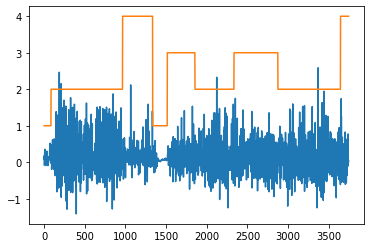

In [14]:
#Visually exploring correlation of data between different variables. 
plt.plot(new_train_data[['z', 'label']])
plt.show()

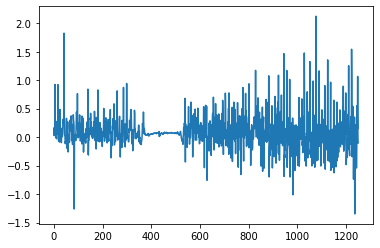

In [15]:
plt.plot(new_test_data[['z', 'label']])
plt.show()

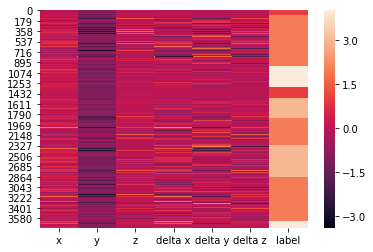

In [16]:
sns.heatmap(data = new_train_data[['x','y', 'z','delta x', 'delta y', 'delta z', 'label']], annot = False)
plt.show()

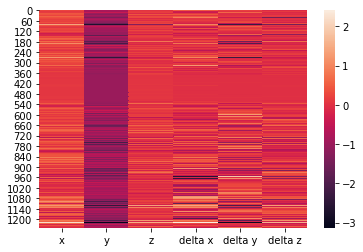

In [17]:
sns.heatmap(data = new_test_data[['x','y', 'z','delta x', 'delta y', 'delta z']], annot = False)
plt.show()

After visually inspecing data and cleaning it, apply models to learn to predict data

In [60]:
#Splitting the data between cleaned input rows and the target for prediction, the labels in this case.
training_col = ['x', 'y','z','NaN']
outcome = ['label']
X_train, X_test, y_train, y_test = train_test_split(new_train_data[training_col],
                                                    new_train_data[outcome], shuffle = True)

In [61]:
#Since values aren't evenly distributed, create a weight to allow the model to evenly deal with them
y_vals = [y for y in y_train['label']]
classes_weight = class_weight.compute_class_weight('balanced', np.unique(y_train.values),y_vals)
weight = dict(zip(np.unique(y_train.values),classes_weight))

Since this is a classification problem, its better to use a logistic regression, random forest or nearest neighbor model to determine the results

In [62]:
#Create a models to classify the data 
lr = LogisticRegression(warm_start = True)
fc = RandomForestClassifier(max_depth=10, class_weight = weight)
knn = KNeighborsClassifier(n_neighbors = 5)

In [63]:
#Fit and asses the Linear Regression model
lr.fit(X_train,y_train)
predLR = lr.predict(X_test)
lr.score(X_test, y_test)

C:\Users\etaoi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\etaoi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\etaoi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.5897435897435898

In [64]:
#Fit and assess the Random Forest model
fc.fit(X_train,y_train)
predFC = fc.predict(X_test)
fc.score(X_test,y_test)

C:\Users\etaoi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\etaoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.5598290598290598

In [65]:
#Fit and assess the K Nearest Neighbor model
knn.fit(X_train, y_train)
predKNN = knn.predict(X_test)
knn.score(X_test, y_test)

C:\Users\etaoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.6271367521367521

In [66]:
#A quick peek at the models' predictions, as compared to the actual result. 
print(np.unique(predLR, return_counts = True))
print(np.unique(predFC, return_counts = True))
print(np.unique(predKNN, return_counts = True))
print(np.unique(y_test, return_counts = True))

(array([2.]), array([936], dtype=int64))
(array([1., 2., 3., 4.]), array([ 81, 482, 249, 124], dtype=int64))
(array([1., 2., 3., 4.]), array([ 75, 680, 150,  31], dtype=int64))
(array([1., 2., 3., 4.]), array([ 68, 552, 205, 111], dtype=int64))


In [67]:
#Make a copy of the test to append and compare predictions to graphically, for easy human visual comparison.
compare = y_test.copy()
compare['predFC'] = predFC
compare['predLR'] = predLR
compare['predKNN'] = predKNN

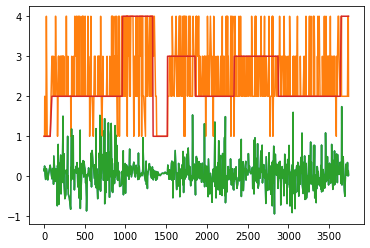

In [68]:
#In these models, the red line represents actual values, and orange represents predicted models.
plt.plot(pd.concat([X_test['z'], compare['predFC']], axis = 1, sort = True))
plt.plot(pd.concat([X_test['z'], y_test], axis = 1, sort = True))
plt.show()

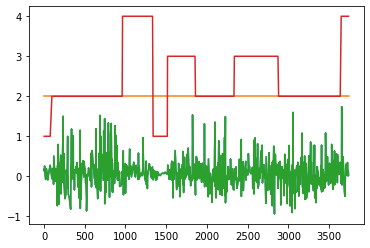

In [69]:
plt.plot(pd.concat([X_test['z'], compare['predLR']], axis = 1, sort = True))
plt.plot(pd.concat([X_test['z'], y_test], axis = 1, sort = True))
plt.show()

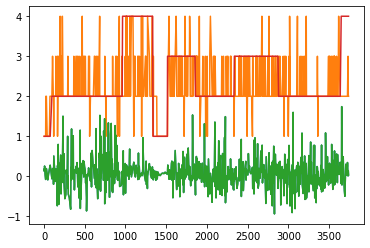

In [70]:
plt.plot(pd.concat([X_test['z'], compare['predKNN']], axis = 1, sort = True))
plt.plot(pd.concat([X_test['z'], y_test], axis = 1, sort = True))
plt.show()

In [71]:
#Here we make predictions and visually inspect the data to see its accuracy with the testing data, which we don't know the actual values of. 
predTestFC = fc.predict(new_test_data[training_col])
predTestLR = fc.predict(new_test_data[training_col])
predTestKNN = knn.predict(new_test_data[training_col])

In [72]:
new_test_data['predTestFC'] = predTestFC
new_test_data['predTestLR'] = predTestLR
new_test_data['predTestKNN'] = predTestKNN

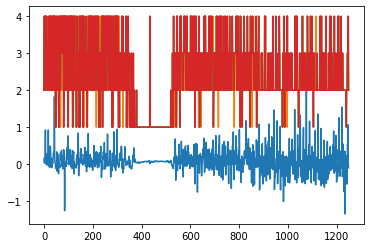

In [73]:
plt.plot(new_test_data[['z', 'predTestKNN', 'predTestLR', 'predTestFC']])
plt.show()

From this plot it can be seen that the prediction models are very accurate when a person is standing still, but fairly innaccurate elsewhere. This appears to be an issue with the model overfitting the data.